In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
import math
import pickle
from collections import Counter,defaultdict
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn import preprocessing
from matplotlib import pyplot
%matplotlib inline

In [2]:
DATA_PATH = "/Users/siva/Documents/interview_preparation/heavy_water_backup/document-classification-test/shuffled-full-set-hashed.csv"

# Reading Dataset

In [3]:
total_data_from_csv = {"labels":[],"documents":[]}
with open(DATA_PATH) as csv_file:
    csv_reader = csv.reader(csv_file)
    for each_row in csv_reader:
        total_data_from_csv["labels"].append(each_row[0])
        total_data_from_csv["documents"].append(each_row[1])
print("Total number of documents:",len(total_data_from_csv["documents"]))
print("Total number of labels:",len(total_data_from_csv["labels"]))

Total number of documents: 62204
Total number of labels: 62204


# Splitting dataset into train and test data

In [4]:
train_data,test_data,train_labels,test_labels = train_test_split(total_data_from_csv["documents"],\
                                                                 total_data_from_csv["labels"],\
                                                                test_size = 0.33)
print("Number of train datapoints:",len(train_data))
print("Number of test datapoints:",len(test_data))

Number of train datapoints: 41676
Number of test datapoints: 20528


## First step before we build machine learning models, we have to understand the data

As a first step, we can analyse the classes distribution

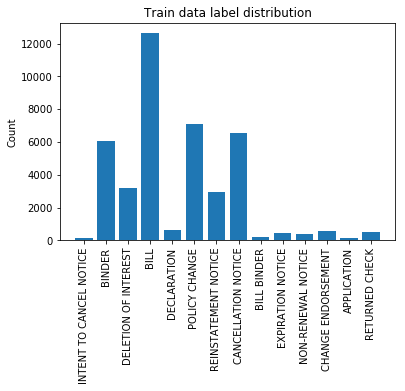

In [5]:
train_labels_distribution = Counter(train_labels)
_ = plt.bar(np.arange(len(train_labels_distribution)),train_labels_distribution.values())
_ = plt.xticks(np.arange(len(train_labels_distribution)),train_labels_distribution.keys(),rotation = 90)
_ = plt.ylabel("Count")
_ = plt.title("Train data label distribution")

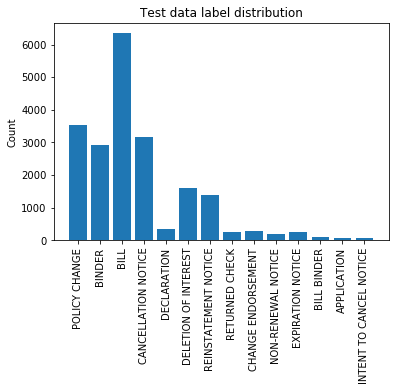

In [6]:
test_labels_distribution = Counter(test_labels)
_ = plt.bar(np.arange(len(test_labels_distribution)),test_labels_distribution.values())
_ = plt.xticks(np.arange(len(test_labels_distribution)),test_labels_distribution.keys(),rotation = 90)
_ = plt.ylabel("Count")
_ = plt.title("Test data label distribution")

## Next we need to select a feature representation of words(hashed words in our case)

I have chosen to go with Tf-idf which works well for text data because of its characteristic to give importance to rarely occuring words 

In [24]:
#finding the features from the documents
vectorizer = TfidfVectorizer(min_df = 0.1,lowercase = False)
#vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(train_data).toarray()
print("Number of features:",train_features.shape[1])

Number of features: 308


In [21]:
#finding the test features with the same vectorizer used for train data
test_features = vectorizer.transform(test_data).toarray()
print("Number of features:",test_features.shape[1])

Number of features: 589


## Another possible study about the data is exploring the eigen value decomposition of the feature matrix

One can find a low-rank approximation to the actual feature matrix which can potentially imporove the performance of the classifier that we are going to use

In [9]:
centered_train_features = train_features - np.mean(train_features,axis = 0)
centered_test_features = test_features - np.mean(test_features,axis = 0)
u,s,v = np.linalg.svd(centered_train_features)
u_test,s_test,v_test = np.linalg.svd(centered_test_features)

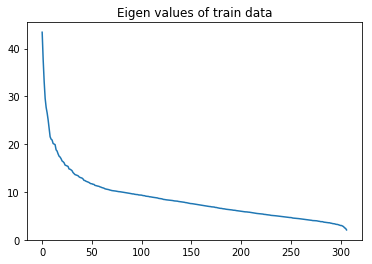

In [10]:
_ = plt.plot(np.arange(len(s)),s)
_ = plt.title("Eigen values of train data")

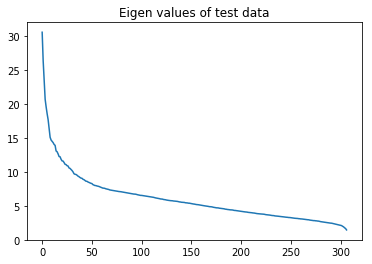

In [11]:
_ = plt.plot(np.arange(len(s_test)),s_test)
_ = plt.title("Eigen values of test data")

## One more possible analysis is data visualization

One can perform dimensionality reduction on the feature matrix and try visualizing in the 2d space

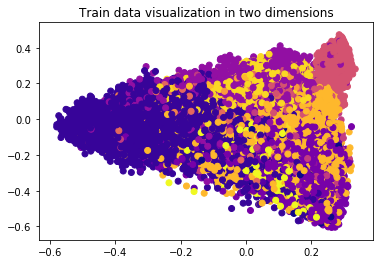

In [12]:
train_data_for_vis = u[:,0:2] @ np.diag(s[0:2])
label_encode = preprocessing.LabelEncoder()
label_encode.fit(np.unique(train_labels))
train_encoded_labels = label_encode.transform(train_labels)
_ = plt.scatter(train_data_for_vis[:,0],train_data_for_vis[:,1],c = train_encoded_labels,cmap = plt.get_cmap("plasma"))
_ = plt.title("Train data visualization in two dimensions")

In [13]:
no_of_features = 100
reduced_train_data = u[:,0:no_of_features] @ np.diag(s[0:no_of_features])
reduced_test_data = u_test[:,0:no_of_features] @ np.diag(s_test[0:no_of_features])
print(reduced_train_data.shape,reduced_test_data.shape)
random_forest_classifier_dim = RandomForestClassifier()
random_forest_classifier_dim.fit(reduced_train_data,train_labels)
print("Accuracy of Random Forest Classifier:",random_forest_classifier_dim.score(reduced_test_data,test_labels))

(41676, 100) (20528, 100)
Accuracy of Random Forest Classifier: 0.0865646921278


In [13]:
#Saving the vectorizer to be used for web demo
with open("vectorizer.pk","wb") as file:
    pickle.dump(vectorizer,file)

## Classifiers

In [14]:
#First tried a simple to check if there is linear relationship between the features and labels using Naive Bayes
#train_features = train_features_[:]
BATCH_SIZE = 1000
Naive_Bayes = MultinomialNB(alpha = 0.01)
for batch in range(math.ceil(train_features.shape[0]/BATCH_SIZE)):
    train_batch_data = train_features[(batch*BATCH_SIZE):(batch+1)*BATCH_SIZE,:]
    train_batch_labels = train_labels[(batch*BATCH_SIZE):(batch+1)*BATCH_SIZE]
    Naive_Bayes.partial_fit(train_batch_data,train_batch_labels,classes = np.unique(train_labels))
#joblib.dump(Naive_Bayes,"Naive_Bayes.pkl") #saving the model for web demo
print("Accuracy of Naive Bayes:",Naive_Bayes.score(test_features,test_labels))

Accuracy of Naive Bayes: 0.707813717849


In [ ]:
#SVM non-linear classifier
svm_classifier = SVC()
svm_classifier.fit(train_features,train_labels)
print("Accuracy of RBF kernel Support Vector Machine:",svm_classifier.score(test_features,test_labels))

In [22]:
#Random forest classifier
random_forest_classifier = RandomForestClassifier(n_estimators = 20)
random_forest_classifier.fit(train_features,train_labels)
print("Accuracy of Random Forest Classifier:",random_forest_classifier.score(test_features,test_labels))

Accuracy of Random Forest Classifier: 0.852007014809


In [23]:
#Gradient Boosting Classifier
gradient_boosting_classifier = GradientBoostingClassifier()
gradient_boosting_classifier.fit(train_features,train_labels)
print("Accuracy of Gradient Boosting classifier:",gradient_boosting_classifier.score(test_features,test_labels))

Accuracy of Gradient Boosting classifier: 0.853858144973


## Performance Metrics

In [16]:
"""
Since the classes distribution is not equal, accuracy is not really good way to measure the performance
of the classifier, therefore used F1 score for the best classifiers
"""
random_forest_predictions = random_forest_classifier.predict(test_features)
#gradient_boosting_predictions = gradient_boosting_classifier.predict(test_features)

print("Random forest classifier f1 score:",f1_score(test_labels,random_forest_predictions,average = "weighted"))
#print("Gradient Boosting f1 score:",f1_score(test_labels,gradient_boosting_predictions,average = "weighted"))

Random forest classifier f1 score: 0.847176315783


In [15]:
#Used to save the random forest and gradient boosting classifier to be used for web demo
#joblib.dump(random_forest_classifier,"random_forest.pkl")
#joblib.dump(gradient_boosting_classifier,"gradient_boosting.pkl")

['gradient_boosting.pkl']

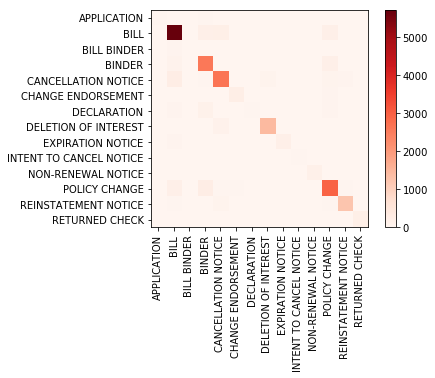

In [17]:
confusion_mat = confusion_matrix(test_labels,random_forest_predictions)
_ = plt.imshow(confusion_mat,interpolation='nearest',cmap = plt.get_cmap("Reds"))
_ = plt.xticks(np.arange(len(np.unique(test_labels))),np.unique(test_labels),rotation = 90)
_ = plt.yticks(np.arange(len(np.unique(test_labels))),np.unique(test_labels))
_ = plt.colorbar()

In [19]:
print(confusion_mat)

[[  32    6    0   33    1    0    1    0    0    0    0    8    0    0]
 [   0 5716   10  181  214    0   19    0    9    2    1  180    9    2]
 [   0   50   16   14    0    0    0    0    0    0    0   16    0    0]
 [   0  105    1 2598    6    2   18    2    1    0    0  180    2    1]
 [   0  253    0   26 2674    0    7   71    2    4    5   69   48    0]
 [   0    3    0   10    2  235    1    0    0    0    0   47    2    0]
 [   1   52    1  146   15    0   41    7    1    0    2   62    7    1]
 [   0    1    0    4  133    1    5 1435    0    0    0   15    6    0]
 [   0   50    0    2    6    0    0    2  186    0    1    7    2    0]
 [   0   10    0    1   21    0    1    1    0   23    0    2    5    0]
 [   0    0    0    1   21    0    1    1    1    0  159   15    7    0]
 [   1  184    4  257   33   26   12   13    8    0    7 2948   29    0]
 [   0   28    0   12   69    0    1    5    3    0    0   44 1230    0]
 [   0   19    0    9    4    0    1    0    0    0

In [28]:
print(test_data[1234],test_labels[1234])

5ffca64090ab 48d657cd9861 4e5019f629a9 3ca8923ce2f0 88086c92524c 2f2548bd374a cdee33987473 25c57acdf805 f2b0e028fe2c 4ad52689d690 a0c020166d79 c337a85b8ef9 f7ae6f8257da 3a29db408753 df330922aae2 cff184767152 eeb86a6a04e4 c20e4813029a 52102c70348d 4ad52689d690 c337a85b8ef9 422068f04236 36e7aa72ffe1 21e314d3afcc 98d0d51b397c ce1f034abb5d e52882a7f2b7 9bc65adc033c 21e314d3afcc 09b305bd6c36 54709b24b45f 1015893e384a 25c57acdf805 586242498a88 6bf9c0cb01b4 0562c756a2f2 c337a85b8ef9 e4dad7cb07b6 3a29db408753 fba17a07a130 afb1e3806fc1 2f2548bd374a b9699ce57810 de9738ee8b24 641356219cbc ce1f034abb5d fb2cd24a447a 0562c756a2f2 431392fb12c7 1b6d0614f2c7 6b343f522f78 515927b56707 88086c92524c d38820625542 bcdd3940ccfc 9e0c01b8b857 6ca2dd348663 9bc65adc033c 21e314d3afcc 9bc65adc033c 6ca2dd348663 ad6c6e2ee8c0 6ce6cc5a3203 d493c688fb66 6a01047db3ab c6053333c7c8 1a8ac9f8f32f d19b1c129f40 4eb37245db2f 4e5019f629a9 07b93136ac77 bf6aecccca19 3689f1b1fc46 0562c756a2f2 52102c70348d 5c27e2a5cfa5 2f516aaa92f4